#  Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import cv2
import yaml
import torch
from PIL import Image
from pathlib import Path

# from shapely.geometry import Polygon
# from shapely.ops import cascaded_union
import skimage
from tqdm import tqdm
from src.dataset import DL_Proj
from src.utils import MODEL_FROM_NAME
from src.dataset import get_dataloaders, get_aug

from ipywidgets import interact
import ipywidgets as widgets
from pytorch_tools.utils.misc import to_numpy
from sklearn.metrics import jaccard_score

import pytorch_tools as pt

# Generate masks

In [11]:
DATA_PATH = Path("/home/zakirov/datasets/DL_data/")
IMG_PATH = DATA_PATH / "output_batches"
all_images = sorted(list(IMG_PATH.iterdir()))

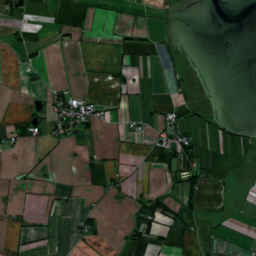

In [12]:
Image.open(all_images[0])

In [13]:
MASKS_PATH = DATA_PATH / "output_shapes"
all_masks = np.array(sorted(list(MASKS_PATH.iterdir())))
mask_image_idx = np.array(list(map(lambda x: int(str(x.name).split('_')[0]), all_masks)))
# check that it's correct
assert len(all_images) == mask_image_idx.max()

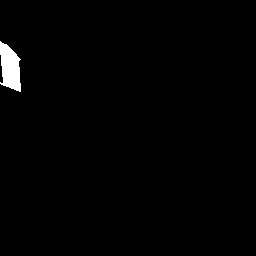

In [6]:
img = Image.open(all_masks[mask_image_idx == 1][15])
img

In [66]:
SIZE = 512

In [68]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # circle kernel
# kernel_3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) # circle kernel

for img_id in tqdm(range(1, mask_image_idx.max() + 1)):
    combined_mask = np.zeros((SIZE, SIZE))
    combined_borders = np.zeros((SIZE, SIZE))
    for i in all_masks[mask_image_idx == img_id]:
        img = np.array(Image.open(i).resize((SIZE, SIZE), resample=Image.BILINEAR), dtype=np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        combined_mask += img / 255
        img = cv2.dilate(img, kernel, iterations = 1)
        combined_borders += img / 255
    combined_mask = (combined_mask > 0).astype(np.uint8) * 255
    combined_borders = (combined_borders > 1).astype(np.uint8) * 255
    # close borders. visually better 
    combined_borders = cv2.morphologyEx(combined_borders, cv2.MORPH_CLOSE, kernel)
    
    cv2.imwrite(f"workdir/segm_masks/{img_id}.png", combined_mask)
    cv2.imwrite(f"workdir/border_masks//{img_id}.png", combined_borders)
#     break


100%|██████████| 900/900 [02:20<00:00,  6.40it/s]


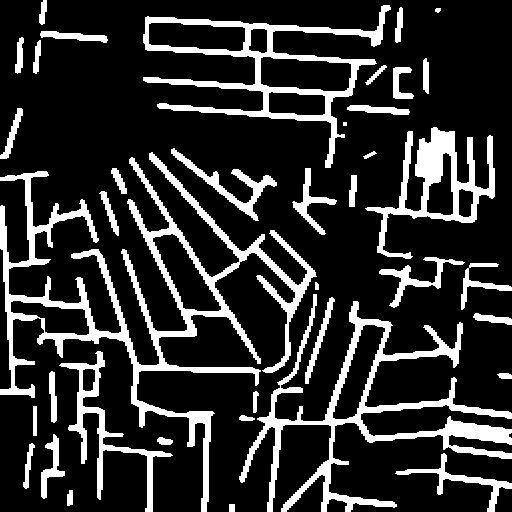

In [65]:
Image.fromarray(combined_borders)

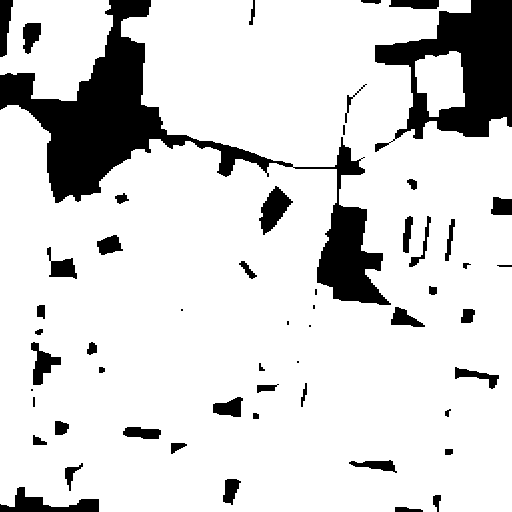

In [66]:
Image.fromarray(combined_mask)

In [16]:
for img_id in tqdm(range(1, mask_image_idx.max() + 1)):
    img_name = f"/home/zakirov/datasets/DL_data/output_batches/{img_id}.png"
    img = np.array(Image.open(img_name).resize((SIZE, SIZE)), dtype=np.uint8)
    cv2.imwrite(f"workdir/images_512//{img_id}.png", img[..., ::-1]) # turn to bgr to save correctly
#     break

100%|██████████| 900/900 [00:11<00:00, 77.65it/s]


# Check Dataset

In [18]:
dtst = DL_Proj(split="val")
len(dtst)

90

In [22]:
img, masks = dtst[80]

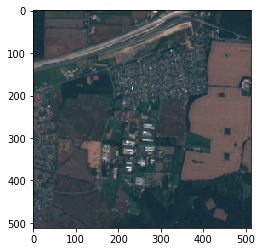

In [23]:
plt.imshow(img)

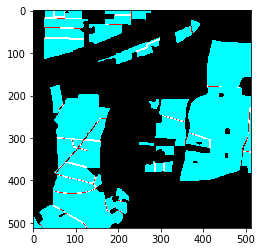

In [24]:
plt.imshow(masks)

In [25]:
masks.shape

(512, 512, 3)

# Vaidate models

In [3]:
PREV_WEIGHTS = None
PREV_MODEL = None
SINGLE_IMG = None
SINGLE_MASK = None
MEAN=(0.485, 0.456, 0.406)
STD=(0.229, 0.224, 0.225)

In [23]:
@interact(
    dataset=["val", "train", "test"],
    weights=sorted(os.listdir("logs/")),
    N=widgets.IntSlider(min=0, max=90, continuous_update=False),
    thr=widgets.FloatSlider(0.5, min=0.2, max=0.8, step=0.1, continuous_update=False),
    
)
def foo(
    dataset="val",
    weights=None, 
    N=0, 
    thr=0.5,
#     adaptive_thr=False,
    use_tta=False, 
#     equilize=False,
#     detect_edges=False,
#     watershed=False,
    overlay_pred=False,
    overlay_true=False,
    use_gmean=False,
):
    global PREV_WEIGHTS
    global PREV_MODEL
    global SINGLE_IMG
    global SINGLE_PRED
    
    if weights is None:
        print("select weights")
        return 
    
    if weights != PREV_WEIGHTS:
        PREV_WEIGHTS = weights
        log_path = "logs/" + weights + "/"
        config = yaml.load(open(log_path + "config.yaml"))
        if "hrnet" in config["segm_arch"]:
            model = MODEL_FROM_NAME[config["segm_arch"]](pretrained=None, **config.get("model_params", {})).cuda()
        else:
            model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
        state_dict = torch.load(log_path + 'model.chpn')["state_dict"]
        if "model." in list(state_dict.keys())[0]:
            # model was trained using tta need to remove `model` from name
            state_dict = {k[6:]:v for k,v in state_dict.items()}
        model.load_state_dict(state_dict, strict=False)
        model.eval()
        PREV_MODEL = model
    
    img, mask = DL_Proj(split=dataset, transform=get_aug("test", size=512))[N]
    
#     input_img = img * torch.Tensor(STD).view(3, 1, 1) + torch.Tensor(MEAN).view(3, 1, 1)
    with torch.no_grad():
        if use_tta:
            model = pt.tta_wrapper.TTA(PREV_MODEL, segm=True, h_flip=True, rotation=[90], merge="gmean" if use_gmean else "mean", activation="sigmoid")
        else:
            model = PREV_MODEL
        pred = model(img.view(1, *img.shape).cuda())
        if isinstance(pred, (tuple, list)):
            pred = pred[1]
        if not use_tta:
            pred.sigmoid_()
    img = to_numpy(img).swapaxes(0, 2)
    img = np.clip((img * STD + MEAN), 0, 1)
#     if equilize:
#         img = albu.Equalize(always_apply=True, by_channels=False)(image=(img * 255).astype(np.uint8))["image"] / 255
    
    mask = to_numpy(mask).swapaxes(0, 2)
#     mask[:, :, :2] = (mask[:, :, :2] + 1) * 0.5
    pred = to_numpy(pred.squeeze()).swapaxes(0, 2)
    
#     if detect_edges:
#         img = auto_canny(img, fixed_thr=True, sigma=0.5)
#         pred = auto_canny(pred, fixed_thr=True)
    thr_mask = (np.clip(pred[..., 1] - pred[..., 0], 0, 1) >  thr).astype(np.uint8)
#     if adaptive_thr:
#         thr_mask = process_adaptive_thr(pred)
#     print(np.unique(mask[:,:,1]), np.unique(thr_mask.T))
#     score = jaccard_score(mask[:,:,1].astype(np.uint8), thr_mask.T.astype(np.uint8), average="micro")
#     if mask[:,:, 2].sum() == 0 and thr_mask.sum() == 0:
#         score = 1
#     if watershed: 
#         img, pred = watershed(img, pred)
    if overlay_pred:
        img[thr_mask == 1] = [1, 0, 0]
    if overlay_true:
        img[mask[:, :, 1] == 1] = [0, 1, 0]
        if overlay_pred:
            img[(mask[:, :, 1] == 1) & (thr_mask == 1)] = [1, 1, 0]
#     pred = np.stack([pred.T] * 3, 2)
    thr_mask = np.stack([thr_mask] * 2, 2)
    
#     print(img.shape, mask.shape, pred.shape, thr_mask.shape)
    stacked = np.hstack([img[..., :2], mask, pred, thr_mask])
    stacked = np.concatenate([stacked, np.zeros((512, 2048, 1))], axis=2)
    plt.figure(figsize=(32,8))
    plt.imshow(stacked, cmap="gray")
#     plt.title(f"Jaccard={score:.3f}", fontdict={"fontsize": 25})
    plt.axis("off")
    SINGLE_IMG = pred
    SINGLE_PRED = thr_mask

interactive(children=(Dropdown(description='dataset', options=('val', 'train', 'test'), value='val'), Dropdown…

# Calculate AP

In [22]:
!ls logs/

_dl_p.1.link_r50_red_f_20200527_192330
_dl_p.1.unet_effb3_red_f_hard_b_ctmx_20200527_200331
_dl_p.1.unet_effb3_red_f_hard_b_ctmx_20200527_200404
_dl_p.1.unet_effb3_red_f_hard_b_ctmx_20200527_200428
_dl_p.1.unet_effb3_red_f_hard_b_ctmx_20200527_200511
_dl_p.1.unet_r50_red_f_20200527_185227
_dl_p.1.unet_r50_red_f_hard_b_20200527_193730
_dl_p.1.unet_r50_red_f_hard_b_ctmx_20200527_195452
_dl_p.1.unet_r50_red_f_hard_b_OS16_20200528_114702
_dl_p.1.unet_r50_red_f_hard_b_OS16_hard_aug_20200528_115154
_dl_p.1.unet_ser50_red_f_hard_b_ctmx_20200527_201511
_dl_p.1.unet_ser50_red_f_hard_b_ctmx_OS16_20200527_202831
_dl_p.1.unet_ser50_red_f_hard_b_OS16_20200527_203042
_dl_p.2.unet_r50_red_f_hard_b_OS16_hard_aug_dice_20200528_115956
_dl_p.2.unet_r50_red_f_hard_b_OS16_hard_aug_dice_20200528_120125
_dl_p.2.unet_ser50_red_f_hard_b_OS16_hard_aug_dice_20200528_123333
_dl_p.3.hrnet_w48_20200528_124158
_dl_p.3.hrnet_w48_l_aug_dice05_20200528_140301
_dl_p.3.hrnet_w48_nov_20200528_150124
_dl_p.3.hrnet_w48_nov_

In [16]:
weights = "_dl_p.3.hrnet_w48_nov_20200528_150124" # mAP@0.5: 0.713, mAR@0.5: 0.615
weights = "_dl_p.3.hrnet_w48_20200528_124158"
weights = "_dl_p.5.hrnet_w48_nov_redf_20200529_155011" # mAP@0.5: 0.644, mAR@0.5: 0.598
weights = "_dl_p.5.hrnet_w48_nov_redf_20200529_155011" # mAP@0.5: 0.644, mAR@0.5: 0.598
weights = "_dl_p.5.hrnet_w48_nov_redf_fixed_20200529_155436" # mAP@0.5: 0.652, mAR@0.5: 0.637

log_path = "logs/" + weights + "/"
config = yaml.load(open(log_path + "config.yaml"))
if "hrnet" in config["segm_arch"]:
    model = MODEL_FROM_NAME[config["segm_arch"]](pretrained=None, **config.get("model_params", {})).cuda()
else:
    model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
state_dict = torch.load(log_path + 'model.chpn')["state_dict"]
model.load_state_dict(state_dict, strict=False)
model = model.eval().requires_grad_(False)
MODEL = pt.tta_wrapper.TTA(model, segm=True, h_flip=True, rotation=[90], merge="gmean", activation="sigmoid").cuda()

In [17]:
val_dtst = DL_Proj("val", transform=get_aug("val", size=512))
val_img_ids = [int(i.split("/")[-1].split(".")[0]) for i in val_dtst.img_ids]

In [18]:
def get_true_mask(img_id, size=512):
    combined_mask = np.zeros((size, size))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # circle kernel
    for idx, i in enumerate(all_masks[mask_image_idx == img_id]):
        img = np.array(Image.open(i).resize((size, size), resample=Image.BILINEAR), dtype=np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        combined_mask += (idx + 1) * (img / 255).astype(np.uint8)
    return combined_mask.astype(np.uint8)

def get_pred_mask(img):
    ## get pred
    if img.dim() == 3:
        img = img.unsqueeze(0)
    pred = MODEL(img.cuda())
    pred = to_numpy(pred.squeeze()).swapaxes(0, 2)
    ## prepare to watershed
    sure_fg = (pred[..., 1] - pred[..., 0]) > 0.6
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # erode slightly to separe thin boundaries
    sure_fg2 = cv2.morphologyEx(sure_fg.astype(np.uint8) * 255, cv2.MORPH_ERODE, kernel, iterations=2)
    sure_bg = (pred[..., 1] < 0.4).astype(np.uint8) * 255
    # label markers
    ret, markers = cv2.connectedComponents(sure_fg2)
    unknown = np.ones_like(sure_bg) * 255 - sure_bg - sure_fg2
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    # only want confident area of predicted mask to be filled
    energy = (pred[..., 1] * (pred[..., 1] > 0.5 )* 255).astype(np.uint8)
    energy = np.repeat(np.expand_dims(energy, 2), 3, 2) # cv2 requires 3 chn images
    # watershed
    markers = cv2.watershed(energy, markers)
    # remove borders and background from markers
    markers = np.clip(markers.T - 1, 0, 255)
    return markers
#     return pred[..., 1]
#     return sure_fg.T

In [19]:
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()
all_results = []
for N in tqdm(range(len(val_dtst))):
# for N in tqdm(range(10)):
    # get prediction and image
    pred = get_pred_mask(val_dtst[N][0])
    true = get_true_mask(val_img_ids[N])

    num_t = len(np.unique(true))
    num_p = len(np.unique(pred))
    ious = np.zeros((num_t, num_p))
    flat_true = true.flatten()
    flat_pred = pred.flatten()
    for un_t_idx, un_t in enumerate(np.unique(true)):
        for un_p_idx, un_p in enumerate(np.unique(pred)):
            intersec = ((flat_true == un_t) & (flat_pred == un_p)).sum()
            union = ((flat_true == un_t) | (flat_pred == un_p)).sum()
            ious[un_t_idx, un_p_idx] = (intersec / (union + 1))
    TP = (ious.max(1) > 0.5).sum()
    FP = num_p - TP
    FN = num_t - TP
    all_results.append((TP, FP, FN))
all_results = np.array(all_results)
        

100%|██████████| 90/90 [03:46<00:00,  2.52s/it]


In [20]:
TP, FP, FN = all_results.sum(0)
mAP = TP / (TP + FP)
mAR = TP / (TP + FN)
mAP, mAR
print(f"mAP@0.5: {mAP:.3f}, mAR@0.5: {mAR:.3f}")

mAP@0.5: 0.652, mAR@0.5: 0.637


In [ ]:
0.7115749525616698, 0.6388415672913118
0.7126334519572953, 0.6150892685736226